In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
import unicodedata
import re
from env import user, password, host, db, protocol
import acquire

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from nltk import ngrams

from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder


# Exercises

Do your work for this exercise in a file named explore.

1. Spam Data
* Load the spam data set.
* Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?
    * spam seems to be urging a reply for some offer or advertisement. ham words seem to be informative or basic daily conversation

* Is there any overlap in the bigrams for the spam data and the ham data?
    * 'call' is a frequent word in both spam and ham

* Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

2. Explore the blog articles using the techniques discussed in the exploration lesson.

3. Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.

# Data Exploration

* In this lesson, we'll be taking a look at a data set that contains SMS messages that are labelled as either a spam text message, or an actual text message.

In [2]:
def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
filename = 'spamham_data'
df.to_csv(filename)

In [4]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]


* Let's first take a look at how many of the messages are spam vs ham:

In [5]:
labels = pd.concat([df.label.value_counts(),
                    df.label.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels


,n,percent
ham,4825,0.865937
spam,747,0.134063


In [6]:
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(df, "label")


,n,percent
ham,4825,0.865937
spam,747,0.134063


Let's break the data up into 3 seperate pieces:

* The words that appear in legitimate text messages.

* The words that appear in spam text messages.

* All of the words.

In [7]:
ham_words = clean(' '.join(df[df.label == 'ham'].text))
spam_words = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))

Once we have a list of words, we can transform it into a pandas Series, which we can then use to show us how often each of the words occurs.

In [8]:
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

spam_freq.head()


call    359
free    216
txt     150
ur      144
text    137
dtype: int64

Now we'll combine these three together to get one resulting data frame that we can work with:

In [9]:
word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()


,all,ham,spam
0,3,0,3
008704050406,2,0,2
0089my,1,0,1
0121,1,0,1
01223585236,1,0,1


We can now use this data set to answer some interesting questions:

* What are the most frequently occuring words?

In [10]:
word_counts.sort_values(by='all', ascending=False).head(10)


,all,ham,spam
call,600,241,359
im,462,449,13
get,397,314,83
ur,384,240,144
go,304,273,31
4,287,168,119
dont,279,257,22
ok,277,272,5
free,275,59,216
know,267,241,26


Are there any words that uniquely identify a spam or ham message?

In [11]:
pd.concat([word_counts[word_counts.spam == 0].sort_values(by='ham').tail(6),
           word_counts[word_counts.ham == 0].sort_values(by='spam').tail(6)])


,all,ham,spam
thats,94,94,0
i_,117,117,0
say,118,118,0
da,132,132,0
later,134,134,0
lor,160,160,0
awarded,38,0,38
18,43,0,43
guaranteed,50,0,50
tone,73,0,73


Text(0.5, 1.0, 'Proportion of Spam vs Ham for the 20 most common words')

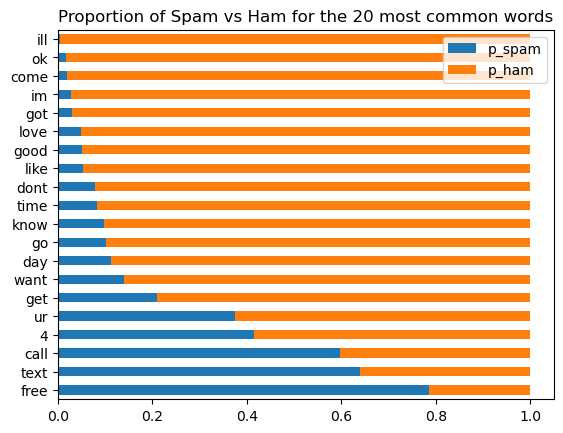

In [12]:
# figure out the percentage of spam vs ham
(word_counts
 .assign(p_spam=word_counts.spam / word_counts['all'],
         p_ham=word_counts.ham / word_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True))

plt.title('Proportion of Spam vs Ham for the 20 most common words')


In [13]:
(word_counts
 [(word_counts.spam > 10) & (word_counts.ham > 10)]
 .assign(ratio=lambda df: df.spam / (df.ham + .01))
 .sort_values(by='ratio')
 .pipe(lambda df: pd.concat([df.head(), df.tail()])))

,all,ham,spam,ratio
im,462,449,13,0.028953
good,235,223,12,0.053809
like,245,232,13,0.056032
need,182,171,11,0.064324
dont,279,257,22,0.085600
contact,70,14,56,3.997145
win,76,15,61,4.063957
cash,74,12,62,5.162365
mobile,150,15,135,8.994004
txt,163,13,150,11.529593


# Word Clouds

The wordcloud allows you to identify the relative frequency of different keywords using an easily digestible visual.

# Common Use Cases

As a visualization technique, this method gives a more qualitative analysis of the topics in the documents.


**Pros**

* It’s intuitive and easy to comprehend.
* It helps identify overall respondent sentiment and the specific factors that drive it.
* It provides direction for further analysis.

**Cons**

* It fails to measure each word’s value in and of itself.
* It allows irrelevant words to appear.
* When words appear similar in size, it becomes difficult to differentiate them.

First we'll take a look at a simple example:

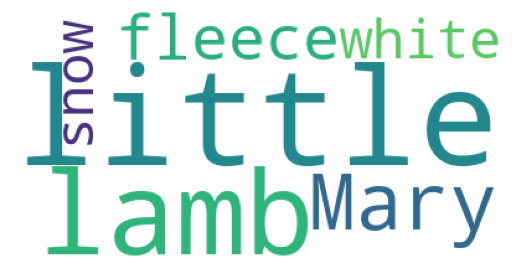

In [14]:
sentence = 'Mary had a little lamb, little lamb, little lamb. Its fleece was white as snow.'

img = WordCloud(background_color='white').generate(sentence)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.show()


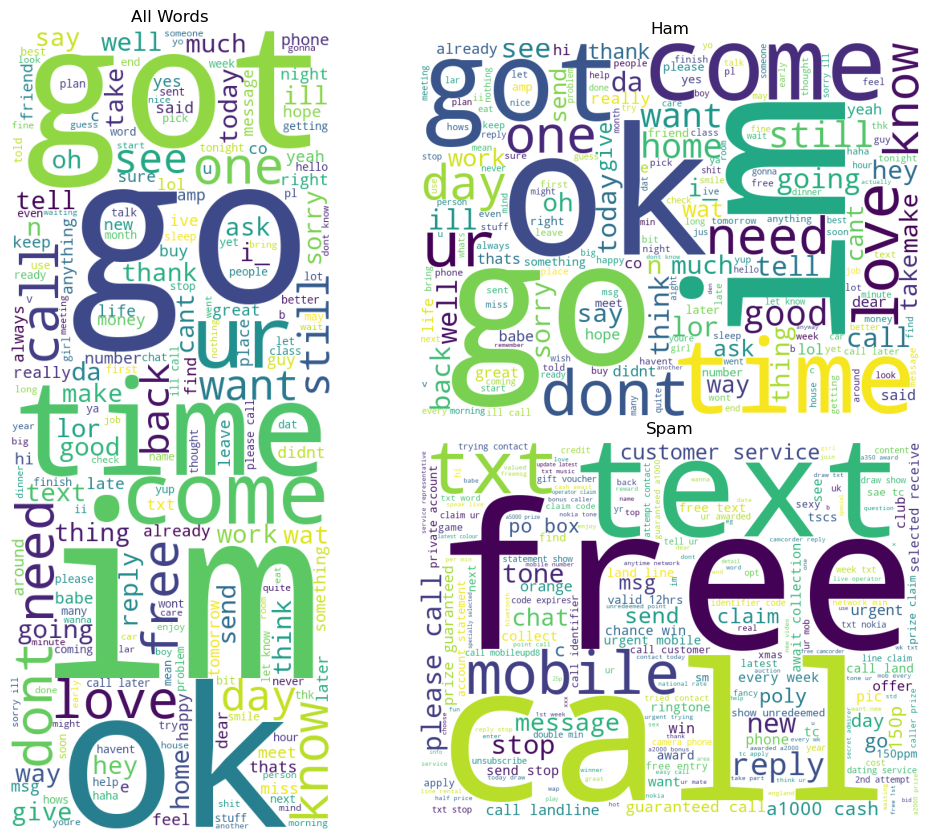

In [15]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
ham_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ham_words))
spam_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(spam_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(ham_cloud)
axs[2].imshow(spam_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Ham')
axs[2].set_title('Spam')

for ax in axs: ax.axis('off')


# Bigrams

Bigrams are a specific instance of the broader concept of n-grams, which is a way to combine words together. This lets us measure not just the individual word frequency, but also takes into account which words appear together.

To produce the bigrams, we'll use nltk.

In [16]:
sentence = 'Mary had a little lamb'

bigrams = nltk.ngrams(sentence.split(), 2)
list(bigrams)


[('Mary', 'had'), ('had', 'a'), ('a', 'little'), ('little', 'lamb')]

We can apply the same transformation to our ham data set in order to find out which bigrams are the most frequently occuring.

In [17]:
top_20_ham_bigrams = (pd.Series(nltk.ngrams(ham_words, 2))
                      .value_counts()
                      .head(20))

top_20_ham_bigrams.head()


(call, later)    52
(ill, call)      48
(let, know)      42
(sorry, ill)     39
(dont, know)     32
dtype: int64

# Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?
* spam seems to be urging a reply for some offer or advertisement. ham words seem to be informative or basic daily conversation

# Is there any overlap in the bigrams for the spam data and the ham data?
* 'call' is a frequent word in both spam and ham


In [18]:
top_20_spam_bigrams = (pd.Series(nltk.ngrams(spam_words, 2))
                      .value_counts()
                      .head(20))

top_20_spam_bigrams.head()

(please, call)         44
(customer, service)    27
(po, box)              24
(a1000, cash)          23
(guaranteed, call)     23
dtype: int64

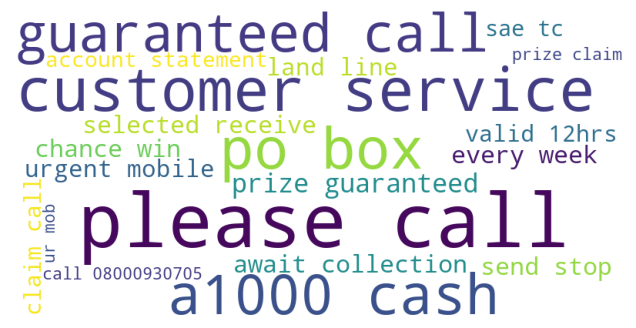

In [19]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_spam_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

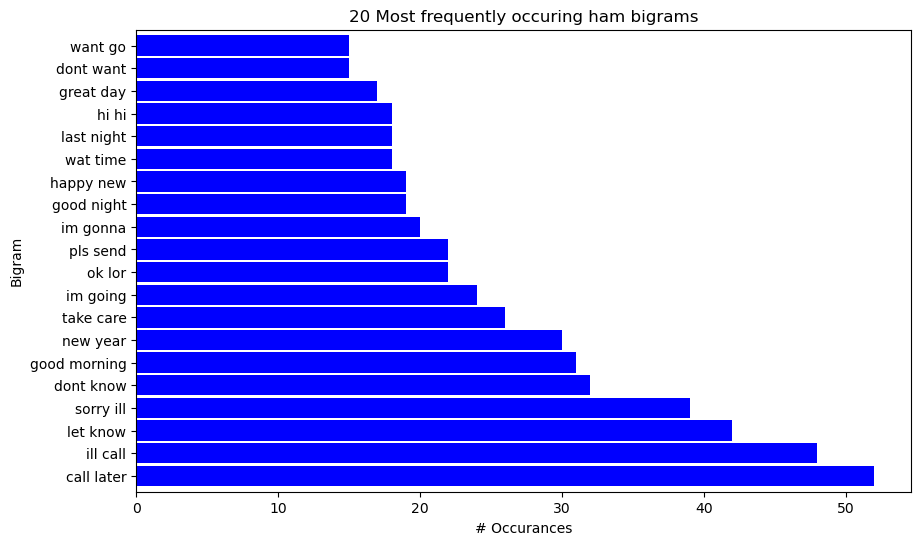

In [20]:
top_20_ham_bigrams.sort_values(ascending=False).plot.barh(color='blue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ham bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ham_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


We can use these bigrams to make a word cloud as well, with a little more effort.

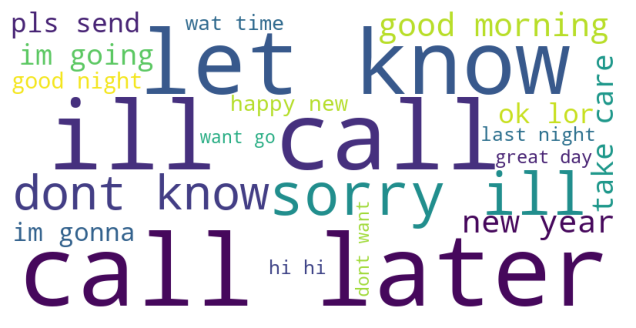

In [21]:
# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
#
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.


data = {k[0] + ' ' + k[1]: v for k, v in top_20_ham_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()


# Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

# Spam

In [22]:
sentence = 'Mary had a little lamb'

trigrams = nltk.ngrams(sentence.split(), 3)
list(trigrams)


[('Mary', 'had', 'a'), ('had', 'a', 'little'), ('a', 'little', 'lamb')]

In [23]:
top_20_spam_trigrams = (pd.Series(nltk.ngrams(spam_words, 3))
                      .value_counts()
                      .head(20))

top_20_spam_trigrams.head()

(prize, guaranteed, call)     21
(call, customer, service)     15
(land, line, claim)           14
(reply, call, 08000930705)    14
(private, 2003, account)      13
dtype: int64

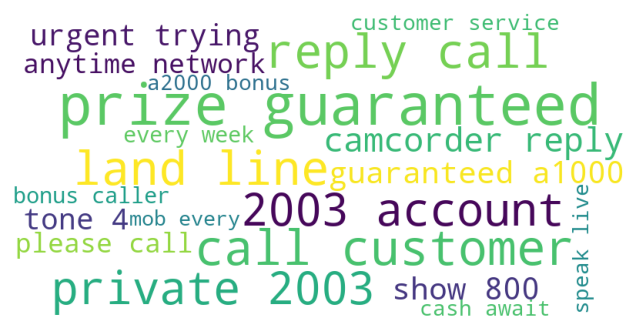

In [24]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_spam_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

# Ham

In [25]:
sentence = 'Mary had a little lamb'

trigrams = nltk.ngrams(sentence.split(), 3)
list(trigrams)


[('Mary', 'had', 'a'), ('had', 'a', 'little'), ('a', 'little', 'lamb')]

In [26]:
top_20_ham_trigrams = (pd.Series(nltk.ngrams(ham_words, 3))
                      .value_counts()
                      .head(20))

top_20_ham_trigrams.head()

(ill, call, later)      42
(sorry, ill, call)      38
(happy, new, year)      19
(pls, send, message)    13
(cant, pick, phone)     12
dtype: int64

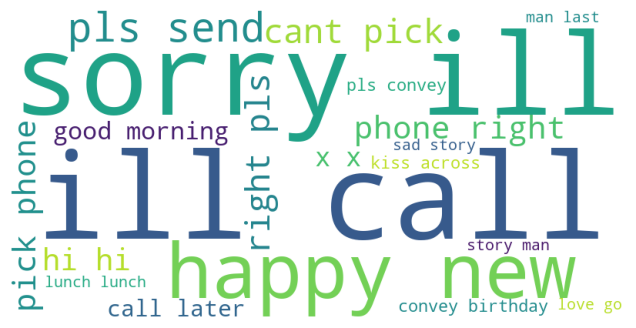

In [27]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_ham_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

# Explore the blog articles using the techniques discussed in the exploration lesson.

In [28]:
news_df = acquire.get_news_articles_data(refresh=False)

In [29]:
codeup_df = acquire.get_blog_articles_data(refresh=False)

# News 

In [30]:
news_df

,title,content,category
0,"WhatsApp responds to int'l calls scam, announc...",WhatsApp has ramped up its AI and machine lear...,national
1,Beyoncé wears colour-changing dress during co...,Singer Beyoncé wore a colour-changing dress d...,national
2,"Complaint filed against Prabhas, Kriti Sanon's...",A complaint has been filed against Prabhas and...,national
3,"Gauahar Khan, Zaid Darbar blessed with a baby boy",Actress Gauahar Khan and her husband Zaid Darb...,national
4,"Yuzvendra Chahal creates history, takes most w...",RR leg-spinner Yuzvendra Chahal has created hi...,national
...,...,...,...
295,Elderly woman hit by police motorcycle escorti...,An elderly woman in her 80s was left criticall...,automobile
296,Video shows British WW II bomb being detonated...,A video has surfaced showing a British World W...,automobile
297,Poland's decision to rename Kaliningrad is a h...,Reacting to Poland's decision of renaming the ...,automobile
298,Gautam Adani's 3 firms planning to raise $5 bi...,Billionaire Gautam Adani-led three companies a...,automobile


# Word Cloud

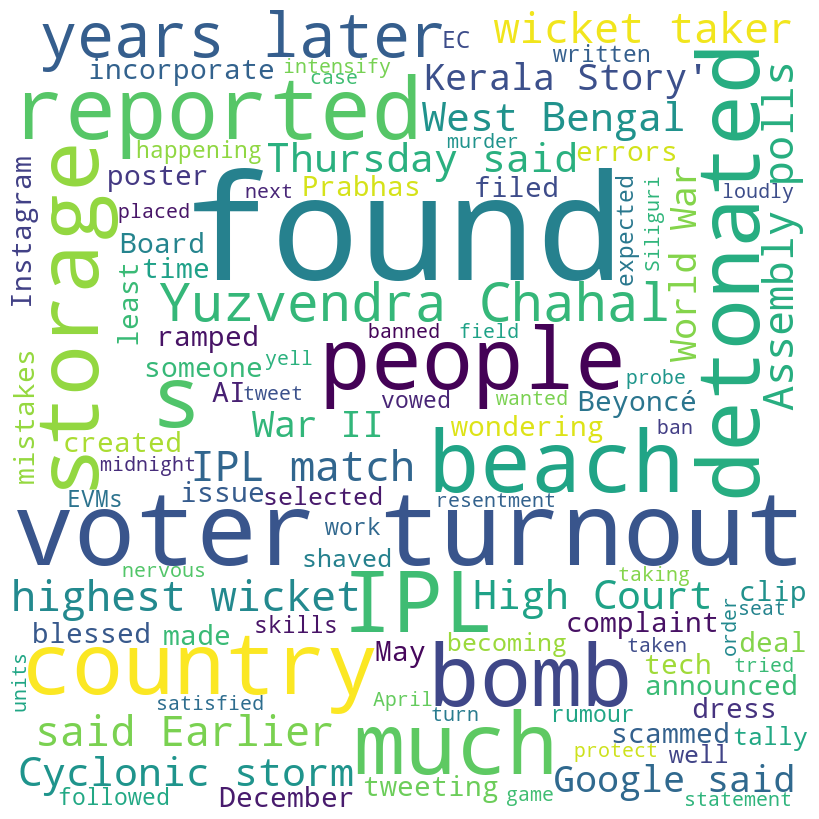

In [31]:
# combine all the article texts into a single string
text = ' '.join(news_df['content'])

# generate the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=100).generate(text)

# plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


# Bigrams

In [32]:
# tokenize the text
tokens = nltk.word_tokenize(text)

# create a bigram finder
bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(tokens)

# apply filters to the bigrams
finder.apply_freq_filter(3)
finder.apply_word_filter(lambda word: word in nltk.corpus.stopwords.words('english'))

# get the top 10 bigrams by PMI
bigrams = finder.nbest(bigram_measures.pmi, 10)

# print the top 10 bigrams
print("The top 10 bigrams by PMI:")
for bigram in bigrams:
    print(bigram)


The top 10 bigrams by PMI:
('183', 'scalps')
('30', 'kg')
('AAP', 'government')
('Actress', 'Gauahar')
('Adani-led', 'three')
('Adidas', 'CEO')
('Alexis', 'Ohanian')
('Almonda', 'Cave')
('An', 'elderly')
('Arrived', '10th')


# Trigams

In [33]:
# combine all the article texts into a single string
text = ' '.join(news_df['content'])

# tokenize the text
tokens = nltk.word_tokenize(text)

# generate trigrams
trigrams = list(ngrams(tokens, 3))


In [34]:
print("Example trigrams:")
for i in range(5):
    print(next(iter(trigrams)))


Example trigrams:
('WhatsApp', 'has', 'ramped')
('WhatsApp', 'has', 'ramped')
('WhatsApp', 'has', 'ramped')
('WhatsApp', 'has', 'ramped')
('WhatsApp', 'has', 'ramped')


In [35]:
# count the frequency of each trigram
freq_dist = nltk.FreqDist(trigrams)

# print the most common trigrams
print("The most common trigrams:")
for trigram, count in freq_dist.most_common(10):
    print(f"{trigram}: {count}")

The most common trigrams:
(',', '``', 'I'): 36
(',', "''", 'the'): 24
('``', 'I', 'was'): 24
('.', 'The', 'complaint'): 24
('highest', 'wicket-taker', 'in'): 24
('wicket-taker', 'in', 'IPL'): 24
('IPL', '2023', 'match'): 24
('said', ',', '``'): 24
('.', "''", 'He'): 24
('said', '.', 'Earlier'): 24


# Blog 

In [36]:
codeup_df

,title,content
0,Women in tech: Panelist Spotlight – Magdalena ...,\nCodeup is hosting a Women in Tech Panel in h...
1,Women in tech: Panelist Spotlight – Rachel Rob...,\nCodeup is hosting a Women in Tech Panel in h...
2,Women in Tech: Panelist Spotlight – Sarah Mellor,\nCodeup is hosting a Women in Tech Panel in ...
3,Women in Tech: Panelist Spotlight – Madeleine ...,\nCodeup is hosting a Women in Tech Panel in h...
4,Black Excellence in Tech: Panelist Spotlight –...,\n\nCodeup is hosting a Black Excellence in Te...
5,Black excellence in tech: Panelist Spotlight –...,\nCodeup is hosting our second Black Excellenc...


# Word Cloud

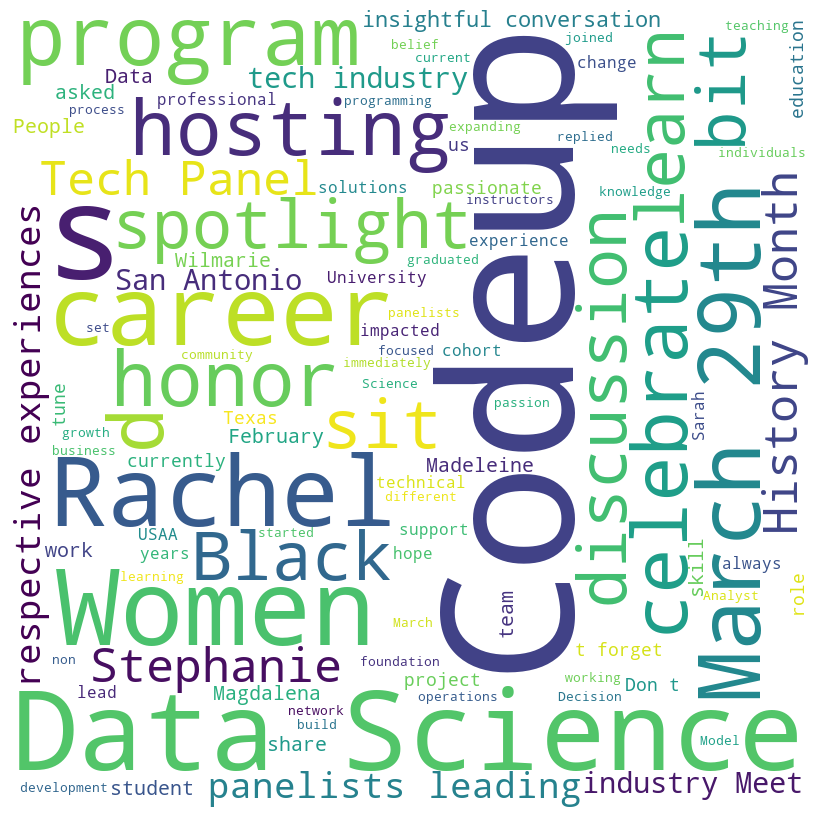

In [37]:
# combine all the article texts into a single string
text = ' '.join(codeup_df['content'])

# generate the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=100).generate(text)

# plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# Bigrams

In [38]:
# combine all the article texts into a single string
text = ' '.join(codeup_df['content'])

# tokenize the text
tokens = nltk.word_tokenize(text)

# create a bigram finder
bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(tokens)

# apply filters to the bigrams
finder.apply_freq_filter(3)
finder.apply_word_filter(lambda word: word in nltk.corpus.stopwords.words('english'))

# get the top 10 bigrams by PMI
bigrams = finder.nbest(bigram_measures.pmi, 10)

# print the top 10 bigrams
print("The top 10 bigrams by PMI:")
for bigram in bigrams:
    print(bigram)


The top 10 bigrams by PMI:
('History', 'Month')
('San', 'Antonio')
('Tech', 'Panel')
('insightful', 'conversation')
('respective', 'experiences')
('We', 'asked')
('panelists', 'leading')
('data', 'science')
('tech', 'industry')
('”', 'Don')


# Trigrams

In [39]:
# combine all the article texts into a single string
text = ' '.join(codeup_df['content'])

# tokenize the text
tokens = nltk.word_tokenize(text)

# generate trigrams
trigrams = list(ngrams(tokens, 3))


In [40]:
print("Example trigrams:")
for i in range(5):
    print(next(iter(trigrams)))


Example trigrams:
('Codeup', 'is', 'hosting')
('Codeup', 'is', 'hosting')
('Codeup', 'is', 'hosting')
('Codeup', 'is', 'hosting')
('Codeup', 'is', 'hosting')


In [41]:
# count the frequency of each trigram
freq_dist = nltk.FreqDist(trigrams)

# print the most common trigrams
print("The most common trigrams:")
for trigram, count in freq_dist.most_common(10):
    print(f"{trigram}: {count}")


The most common trigrams:
('on', 'March', '29th'): 8
('of', 'our', 'panelists'): 8
('Codeup', 'is', 'hosting'): 6
('in', 'Tech', 'Panel'): 6
('Tech', 'Panel', 'in'): 6
('Panel', 'in', 'honor'): 6
('in', 'honor', 'of'): 6
('History', 'Month', 'on'): 6
(',', '2023', '!'): 6
('2023', '!', 'To'): 6
